# Simulation d'une source constante sauf une année

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [3]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [4]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [5]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"simu_variable")
pathres.mkdir(exist_ok=True)

# Début de l'analyse (avec mapdatasets déjà écrits)

## Création de la géométrie

In [6]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [7]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Reading the model template

In [16]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [17]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 2.12e-12 #2.12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.77

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 1/5.4

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 6.09e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

In [18]:
modelGCnaive, modeldiffnaive = modelGC.copy(), modeldiff.copy()

modelGCnaive.parameters["amplitude"].value = 3e-12
modeldiffnaive.parameters["amplitude"].value = 5e-12

# faire varier les modèles naifs

## Constructing the mask

In [19]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 3*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.75 * u.deg)

mask_fit = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

mask_fit = Map.from_geom(geom, data=mask_fit)

# Ajustement du modèle aux cartes

In [20]:
def fit_dataset(mapdataset):
    
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    #print(table)
    
    #stat = fit.stat_profile(parameter='amplitude')
    
    #cov = result.parameters.covariance
    
    return table, result#, stat# , cov

# Ajustement des données simulées

In [24]:
emin = 1.0*u.TeV
emax = 10*u.TeV

GCflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }
DEflux_distribution = {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }
ExcessCounts =        {2004 : [] ,2005 : [] ,2006 : [] ,2007 : [] ,2008 : [] ,2009 : [] ,
                       2010 : [] ,2011 : [] ,2012 : [] ,2013 : [] ,2014 : [] ,2015 : [] ,
                       2016 : [] ,2017 : [] ,2018 : [] ,2019 : []  }

# à ne définir qu'une fois, puis on rajoute des éléments 
#en prenant soin de laisser k augmenter sans remise à zéro dans les appels successifs de la cellule suivante

k = 0

In [37]:
%%time

k_0 = k

while k < k_0 + 2 :
    #ça fonctionne comme ça, tous les modèles existent indépendamment des datasets donc on peut continuer à 
    datasets_year = Datasets.read(pathma/"datasets_year.yaml")
    
    for year in range(2009,2010):
        # données simulées
        datasets_year[f'map_{year}'].models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy()]
        
        datasets_year[f'map_{year}'].fake(k) 
        
        #print("modèle pour le fake",datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        
        
        ExcessCounts[year].append(np.sum(datasets_year[f'map_{year}'].excess))
        
        # on remet les modèles
        datasets_year[f'map_{year}'].mask_fit = mask_fit
        bkg_model = FoVBackgroundModel(dataset_name=f"map_{year}")
        
        # partir de différentes valeur pour le fit pour chaque iteration
        #modelGCnaive.spectral_model.parameters['amplitude'].value = np.random.normal(2,0.3)*1e-12
        
        datasets_year[f'map_{year}'].models =  [modelGCnaive.copy(), modelG09.copy(), modeldiffnaive.copy(),bkg_model]
        #print("modèle pour le fit", datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        
        # on fait le fit
        table, result = fit_dataset(datasets_year[f"map_{year}"])
        
        #print(result)
        
        #plt.plot(stat['amplitude_scan'], stat['stat_scan'])
        
        #print("modèle fitté", datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        #print("erreur fittée", datasets_year[f"map_{year}"].models[0].parameters['amplitude'].error)
        #print(datasets_year[f"map_{year}"].models[0].parameters['amplitude'].error/datasets_year[f"map_{year}"].models[0].parameters['amplitude'].value)
        
        diffuse_flux = datasets_year[f'map_{year}'].models[2].spectral_model.integral(emin, emax)
        GC_flux = datasets_year[f'map_{year}'].models[0].spectral_model.integral(emin, emax)
        
        GCflux_distribution[year].append(GC_flux.value)
        DEflux_distribution[year].append(diffuse_flux.value)
        
    k = k+1

modèle fitté 2.4309541160024384e-12
modèle fitté 1.2648694392245978e-12
CPU times: user 46.2 s, sys: 44 ms, total: 46.2 s
Wall time: 46.2 s


(array([ 5.,  7.,  6., 12.,  8., 18., 10.,  5.,  3.,  1.]),
 array([8.75121604e-13, 9.91199812e-13, 1.10727802e-12, 1.22335623e-12,
        1.33943444e-12, 1.45551265e-12, 1.57159086e-12, 1.68766907e-12,
        1.80374727e-12, 1.91982548e-12, 2.03590369e-12]),
 <a list of 10 Patch objects>)

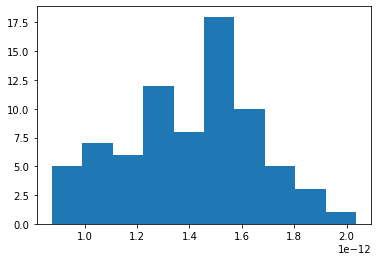

In [36]:
plt.hist(GCflux_distribution[2009])

TypeError: cutout() missing 2 required positional arguments: 'position' and 'width'